# Pool-based Multilabel Active Learning - Birdset Example

> **_Google Colab Note:_** If the notebook fails to run after installing the needed packages, try to restart the runtime (Ctrl + M) under Runtime -> Restart session.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](<colab_link>)

This tutorial aims to demonstrate a practical comparison study using our `scikit-activeml` library in a multi-label classification task. The workflow involves utilizing a self-supervised learning model, specifically `BERT` from [1] but any other text embedding model could be used, to generate embeddings for the AAPD and Reuters-21578 dataset [2,3]. Subsequently, various active learning strategies will be employed to intelligently select samples for labeling.

**Key Steps:**
1. **Self-Supervised Learning Model:** Utilize the `BERT` model to create embedding dataset for BirdSet dataset.

2. **Active Learning Strategies:** Employ different active learning strategies provided by our library, including:
    - Random Sampling
    - Entropy Sampling
    - DropQuery
    - Badge
    - TypiClust
    - MMC (multi-label native)
    - LCI (multi-label native)

3. **Batch Sample Selection:** Use each active learning strategy to select a batch of samples for labeling.

4. **Plotting the results:** By the end of this notebook, we'll compare the accuracy of the aforementioned active learning strategies.

**References:**

[1] Devlin, J., Chang, M., Lee, K., & Toutanova, K. (2019). BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding. North American Chapter of the Association for Computational Linguistics.

[2] Yang, P., Sun, X., Li, W., Ma, S., Wu, W., & Wang, H. (2018). SGM: Sequence Generation Model for Multi-label Classification. International Conference on Computational Linguistics.

[3] Padmanabhan, D., Bhat, S., Shevade, S.K., & Narahari, Y. (2016). Topic Model Based Multi-Label Classification from the Crowd. ArXiv, abs/1604.00783.

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
!wget

In [2]:
# !pip install scikit-activeml
# #!pip install datasets==2.21.0 # optional if processed datasets are uploaded to HF
# !pip install sentence-transformer

## Feature extraction with embedding model

In [3]:
from tqdm.notebook import tqdm
import os

import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt

from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

from skactiveml.classifier import SklearnMultilabelClassifier, SklearnClassifier
from skactiveml.pool import RandomSampling, UncertaintySampling, DropQuery, Badge, TypiClust, SubSamplingWrapper, MMC, LabelCardinalityInconsistency, CoreSet
from skactiveml.utils import MISSING_LABEL, call_func

from sentence_transformers import SentenceTransformer, models

import warnings
mlp.rcParams["figure.facecolor"] = "white"
warnings.filterwarnings("ignore")

2025-05-08 13:56:06.936051: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-08 13:56:06.951116: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-08 13:56:06.955765: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-08 13:56:06.967260: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-08 13:56:07.598370: W tensorflow/compiler/tf2

In [ ]:
def topk_accuracy(preds, targets, topk=1):
    """
    Compute the Top-K Accuracy for multi-class or multi-label predictions using NumPy.

    Args:
        preds (np.ndarray): Prediction probabilities of shape (N, C).
        targets (np.ndarray): One-hot encoded ground truth labels of shape (N, C).
        topk (int): Number of top predictions to consider.

    Returns:
        float: Top-K accuracy.
    """
    # Get the indices of the top-k predictions
    topk_pred_indices = np.argsort(-preds, axis=1)[:, :topk]

    # Convert one-hot encoded targets to indices for positive cases
    correct_positive = np.any(targets[np.arange(targets.shape[0])[:, None], topk_pred_indices], axis=1)

    # Combine correct predictions
    correct = correct_positive.sum()

    # Determine total number of samples to consider
    total = len(targets)

    # Compute accuracy
    accuracy = correct / total if total > 0 else 0.0

    return accuracy

### Setup Embedding model
We setup `Bert` as an embedding model from Huggingface using `sentence_transformers` with a pooling layer utilizing the `[CLS]` token, other models be better utilized with mean pooling.

In [4]:
model_name = 'google-bert/bert-base-uncased'
word_embedding_model = models.Transformer(model_name, cache_dir="hf_model_cache")
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), pooling_mode="cls")
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])
model.cuda()

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

### Setup datasets
Additionally to the audio classification task we showcase two examples from the NLP domain.

1. **AAPD** [LINK](https://git.uwaterloo.ca/jimmylin/Castor-data/-/tree/master/datasets/AAPD/data) dataset including abstracts of papers form arXiv and classifying their categories.
2. **Reuters-21578** [LINK](http://kdd.ics.uci.edu/databases/reuters21578/reuters21578.html) this dataset is one of the most widely used data collections for text categorization research. It is collected from the Reuters financial newswire service in 1987.

In [5]:
# AAPD dataset
with open('data/aapd_raw/text_train.txt', 'r') as file:
    text_train = file.readlines()
with open('data/aapd_raw/label_train.txt', 'r') as file:
    label_train = file.readlines()
with open('data/aapd_raw/text_test.txt', 'r') as file:
    text_test = file.readlines()
with open('data/aapd_raw/label_test.txt', 'r') as file:
    label_test = file.readlines()

text_train = list(map(lambda x: x[:-1], text_train))
label_train = list(map(lambda x: x[:-1].split(" "), label_train))
text_test = list(map(lambda x: x[:-1], text_test))
label_test = list(map(lambda x: x[:-1].split(" "), label_test))
mlb = MultiLabelBinarizer()
Y_true = mlb.fit_transform(label_train)
Y_test = mlb.transform(label_test)
if os.path.exists("data/aapd_raw/embed_train.npy"):
    X = np.load("data/aapd_raw/embed_train.npy")
    X_test = np.load("data/aapd_raw/embed_test.npy")
else:
    X = np.stack([model.encode(text) for text in tqdm(text_train, desc="Train")])
    X_test = np.stack([model.encode(text) for text in tqdm(text_test, desc="Test")])
    np.save("data/aapd_raw/embed_train.npy", X)
    np.save("data/aapd_raw/embed_test.npy", X_test)

In [6]:
for i in range(5):
    print(f"Label: {label_train[i]}\nText: {text_train[i][:70]}...\n")

Label: ['cs.IR', 'stat.ME']
Text: the relation between pearson 's correlation coefficient and salton 's ...

Label: ['quant-ph', 'cs.IT', 'math.IT']
Text: the present work studies quantum and classical correlations in three q...

Label: ['stat.AP', 'cs.CV']
Text: one of the most important tasks in image processing problem and machin...

Label: ['cs.IT', 'math.IT', 'stat.AP']
Text: frequency diverse \( fd \) radar waveforms are attractive in radar res...

Label: ['cs.CL', 'cs.AI']
Text: unsupervised word embeddings have been shown to be valuable as feature...



In [7]:
# reuters dataset
import pandas as pd
train = pd.read_csv("data/reuters/ModApte_train.csv")
test = pd.read_csv("data/reuters/ModApte_test.csv")
train = train[~train["text"].isna()]
test = test[~test["text"].isna()]
label_train = list(map(lambda x: x.replace("\n", "").replace("' '", "','"), train["topics"].to_list()))
label_train = list(map(eval, label_train))
label_test = list(map(lambda x: x.replace("\n", "").replace("' '", "','"), test["topics"].to_list()))
label_test = list(map(eval, label_test))

text_train = train["text"].to_list()
text_test = test["text"].to_list()
mlb = MultiLabelBinarizer()
Y_true = mlb.fit_transform(label_train)
Y_test = mlb.transform(label_test)
if os.path.exists("data/reuters/embed_train.npy"):
    X = np.load("data/reuters/embed_train.npy")
    X_test = np.load("data/reuters/embed_test.npy")
else:
    X = np.stack([model.encode(text) for text in tqdm(text_train, desc="Train")])
    X_test = np.stack([model.encode(text) for text in tqdm(text_test, desc="Test")])
    np.save("data/reuters/embed_train.npy", X)
    np.save("data/reuters/embed_test.npy", X_test)

In [35]:
for i in range(5):
    print(f"Label: {label_train[i]}\nText: {text_train[i][:100]}...\n")

Label: ['cocoa']
Text: Showers continued throughout the week in
the Bahia cocoa zone, alleviating the drought since early
J...

Label: ['grain', 'wheat', 'corn', 'barley', 'oat', 'sorghum']
Text: The U.S. Agriculture Department
reported the farmer-owned reserve national five-day average
price th...

Label: ['veg-oil', 'linseed', 'lin-oil', 'soy-oil', 'sun-oil', 'soybean', 'oilseed', 'corn', 'sunseed', 'grain', 'sorghum', 'wheat']
Text: Argentine grain board figures show
crop registrations of grains, oilseeds and their products to
Febr...

Label: []
Text: Moody's Investors Service Inc said it
lowered the debt and preferred stock ratings of USX Corp and
i...

Label: ['earn']
Text: Champion Products Inc said its
board of directors approved a two-for-one stock split of its
common s...



In [8]:
# parameter setup
n_cycles: int = 20
seed: int = 42
batch_size: int = 30

In [9]:
strategies = {
    "Random": RandomSampling(random_state=seed),
    "Entropy_sum": UncertaintySampling("entropy", random_state=seed, ml_agg=np.nansum),
    "Entropy_max": UncertaintySampling("entropy", random_state=seed, ml_agg=np.max),
    "LeastConfident_sum": UncertaintySampling(random_state=seed, ml_agg=np.nansum),
    "LeastConfident_max": UncertaintySampling(random_state=seed, ml_agg=np.max),
    "DropQuery_sum": DropQuery(random_state=seed, multilabel_aggregation_fn=np.sum),
    "DropQuery_max": DropQuery(random_state=seed, multilabel_aggregation_fn=np.max),
    "Badge": Badge(random_state=seed),
    "Typiclust": TypiClust(random_state=seed),
    "MMC": MMC(random_state=seed),
    "LCI": LabelCardinalityInconsistency(random_state=seed),
    "CoreSet": CoreSet(random_state=seed)
  }
if X.shape[0] > 5_000:
    strategies = {k: SubSamplingWrapper(v, exclude_non_subsample=True, max_candidates=5000) for k,v in strategies.items()}

In [ ]:
history_t1 = {name: [] for name in strategies.keys()}
history_f1 = {name: [] for name in strategies.keys()}

for name, qs in strategies.items():
    clf = SklearnMultilabelClassifier(MultiOutputClassifier(LogisticRegression(random_state=seed, n_jobs=-1, max_iter=500), n_jobs=-1), classes=np.arange(Y_true.shape[-1]), random_state=seed)
    discriminator = SklearnClassifier(LogisticRegression(n_jobs=-1, random_state=seed))

    Y = np.full(shape=Y_true.shape, fill_value=MISSING_LABEL)
    clf.fit(X, Y)
    history_t1[name].append(topk_accuracy(clf.predict(X_test), Y_test))
    history_f1[name].append(f1_score(clf.predict(X_test), Y_test, average="micro"))
    for c in tqdm(range(n_cycles), desc=name):
        query_idx = call_func(qs.query, X=X, y=Y, discriminator=discriminator, clf=clf, fit_clf=False, batch_size=batch_size)

        Y[query_idx] = Y_true[query_idx]
        clf.fit(X, Y)

        history_t1[name].append(topk_accuracy(clf.predict(X_test), Y_test))
        history_f1[name].append(f1_score(clf.predict(X_test), Y_test, average="micro"))

In [13]:
def plot_results(histories):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, tight_layout=True)
    for ax, (metric, history) in zip(axes, histories.items()):
        for name, hist in history.items():
            ax.plot(hist, label=name)
        ax.set_title(metric)
        ax.grid(True)
    fig.legend(*axes[0].get_legend_handles_labels(), loc="upper center", bbox_to_anchor=(0.5, 1), ncol=8)
    fig.suptitle(f"AAPD with batch size of {batch_size}", size=20, y=1.1)
    fig.supylabel("Performance")
    fig.supxlabel("Cycles")
    plt.show()

### AAPD results

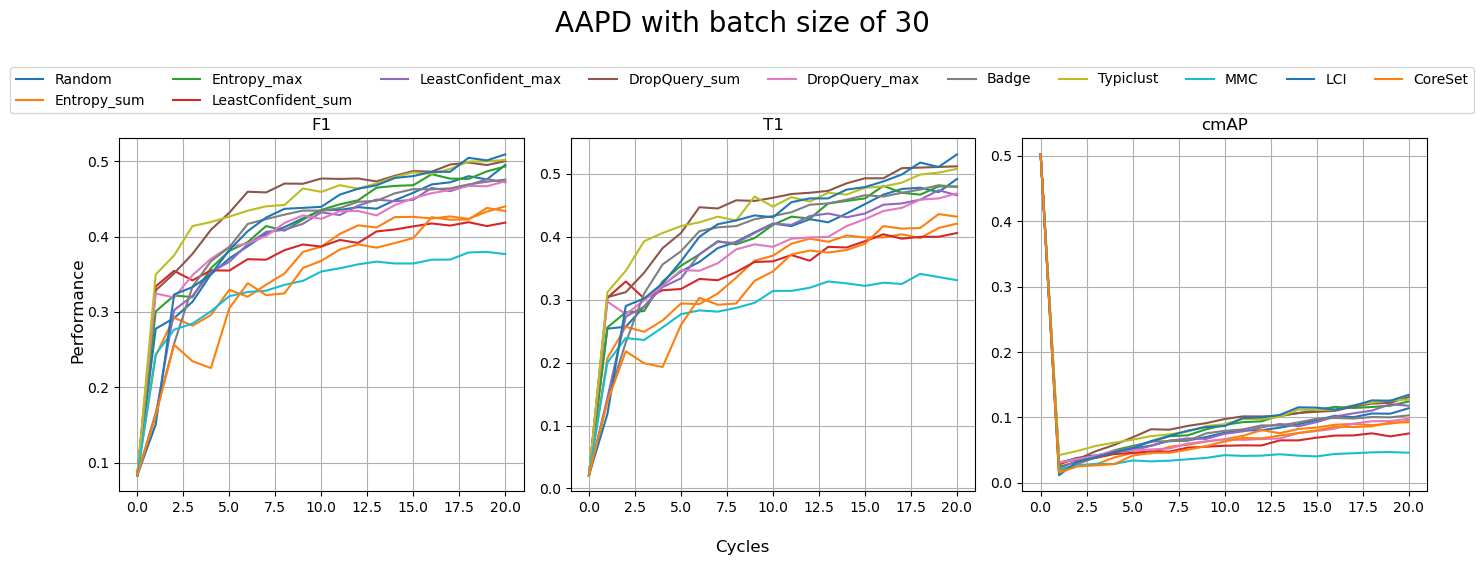

In [18]:
histories = {"F1": history_f1, "T1": history_t1}
plot_results(histories)


### Reuters-21578 results

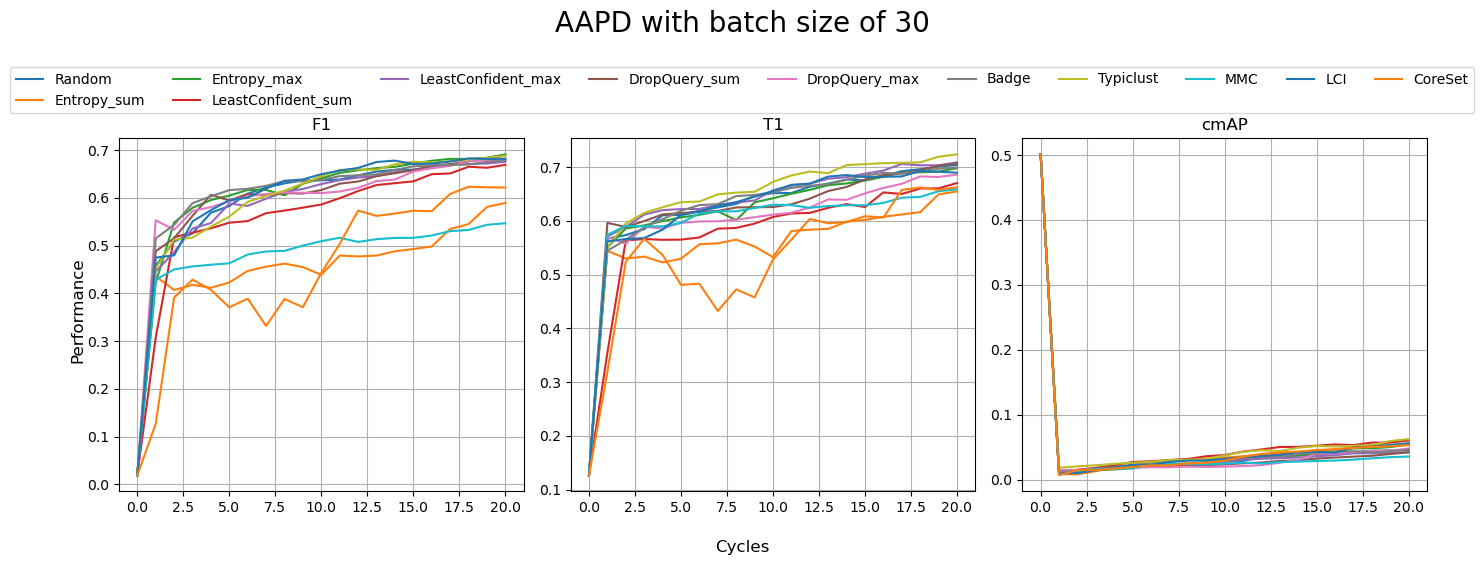

In [12]:
histories = {"F1": history_f1, "T1": history_t1}
plot_results(histories)